In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
import networkx as nx
import plotly.graph_objects as go

#Загрузка данных
all_data = pd.read_csv('m.csv')
print(all_data)

              shrimp            almonds      avocado    vegetables mix  \
0            burgers          meatballs         eggs               NaN   
1            chutney                NaN          NaN               NaN   
2             turkey            avocado          NaN               NaN   
3      mineral water               milk   energy bar  whole wheat rice   
4     low fat yogurt                NaN          NaN               NaN   
...              ...                ...          ...               ...   
7495          butter         light mayo  fresh bread               NaN   
7496         burgers  frozen vegetables         eggs      french fries   
7497         chicken                NaN          NaN               NaN   
7498        escalope          green tea          NaN               NaN   
7499            eggs    frozen smoothie  yogurt cake    low fat yogurt   

     green grapes whole weat flour yams cottage cheese energy drink  \
0             NaN              NaN  NaN 

Данные представляют собой список покупок в продуктовом магазине(market-basket-optimisation)

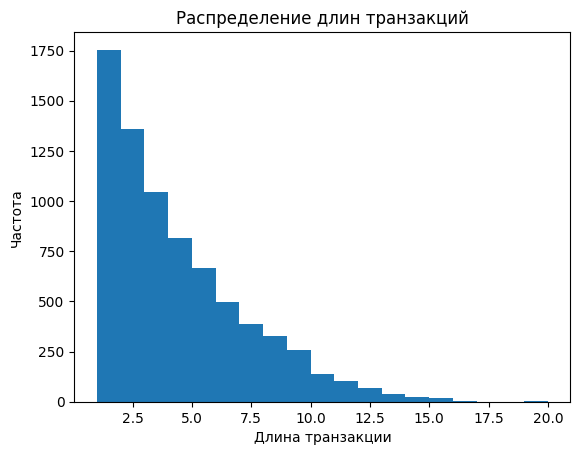

{'candy bars', 'butter', 'asparagus', 'fresh tuna', 'ham', 'protein bar', 'water spray', 'oatmeal', 'whole weat flour', 'rice', 'light cream', 'frozen vegetables', 'ground beef', 'eggs', 'body spray', 'light mayo', 'sandwich', 'spinach', 'almonds', 'energy bar', 'black tea', 'melons', 'pet food', 'shampoo', 'mint green tea', 'strong cheese', 'meatballs', 'cauliflower', 'cookies', 'spaghetti', 'toothpaste', 'napkins', 'pasta', 'salad', 'bacon', 'white wine', 'tomatoes', 'turkey', 'cooking oil', 'green beans', 'whole wheat pasta', 'pepper', 'avocado', 'tomato sauce', 'magazines', 'soda', 'french fries', 'grated cheese', 'chocolate bread', 'muffins', 'antioxydant juice', 'corn', 'babies food', 'french wine', 'olive oil', 'shallot', 'strawberries', 'parmesan cheese', 'oil', ' asparagus', 'clothes accessories', 'herb & pepper', 'cake', 'champagne', 'tomato juice', 'hot dogs', 'cider', 'red wine', 'whole wheat rice', 'ketchup', 'escalope', 'frozen smoothie', 'zucchini', 'cottage cheese', 'mi

In [28]:
#Анализ транзакций
transaction_lengths = all_data.notnull().sum(axis=1)
plt.hist(transaction_lengths, bins=range(1, max(transaction_lengths) + 2))
plt.xlabel('Длина транзакции')
plt.ylabel('Частота')
plt.title('Распределение длин транзакций')
plt.show()

#Очистка данных
np_data = all_data.to_numpy()
#Уберу срез raw[1:], т.к. в датасете написаны транзакции без лишних элементов
np_data = [[elem for elem in row if isinstance(elem, str)] for row in np_data]

#Список уникальных товаров
unique_items = set()
for row in np_data:
    for elem in row:
        unique_items.add(elem)
print(unique_items)

Проведем анализ выборки. На графике изображено распределение количества продуктов в покупательской корзине - оно явно экспоненциальное. Выведем продукты с помощью set().

In [29]:
te = TransactionEncoder()
te_ary = te.fit(np_data).transform(np_data)
data = pd.DataFrame(te_ary, columns=te.columns_)


Алгоритмы Apriori и FPGrowth требуют на вход бинарную матрицу A, где j-ый столбец - j-ый товар, i-ая строка - i-ая тарнзакция, aij = 1, если товар входит в транзакцию.

In [30]:
#Алгоритм Apriori
df1 = apriori(data, min_support=0.02, use_colnames = True)
print(df1)
rules = association_rules(df1, metric = "confidence", min_threshold = 0.25)
print(rules)

      support                           itemsets
0    0.020267                          (almonds)
1    0.033200                          (avocado)
2    0.033733                         (brownies)
3    0.087200                          (burgers)
4    0.030133                           (butter)
..        ...                                ...
99   0.020133  (mineral water, whole wheat rice)
100  0.022933             (spaghetti, olive oil)
101  0.025200              (spaghetti, pancakes)
102  0.021200                (spaghetti, shrimp)
103  0.020933              (spaghetti, tomatoes)

[104 rows x 2 columns]
            antecedents      consequents  antecedent support  \
0             (burgers)           (eggs)            0.087200   
1             (burgers)   (french fries)            0.087200   
2             (burgers)  (mineral water)            0.087200   
3                (cake)  (mineral water)            0.081067   
4             (chicken)  (mineral water)            0.060000   
5   

(п.3 и п.6)
Применили метод Apriori, задав минимальный уровень поддержки(support) в 2%. Таким образом формируется список продуктов(и их комбинаций), встречающиеся хотя бы в 2% транзакций. Получено 104 результата. Далее используем функцию association_rules() с метрикой confidence(A => B) = support(A, B)/support(A), которая берет только те ассоциативные правила, где вероятность встретить продукт B в транзакции, при условии наличия A, равняется 25%. Важен и показатель lift(A, B) = confidencde(A => B)/support(B), который показывает, насколько сильнее правило A => B случайной связи A и B. Будем относить правила с показателем lift = 1(примерно 1) к тривиальным, полезные - наоборот.

Проанализируем результаты. К наиболее полезным правилам можно отнести сочетания:
ground beef - spaghetti, где lift = 2.29, confidence = 0.39
olive oil - spathetti, где lift = 2, confidence = 0.34
soup - mineral water, где lift = 1.9, confidence = 0.45
К наиболее тривиальным правилам:
eggs - mineral whater, где lift = 1.18(почти независимы), confidence = 0.28(немного, относительно других ассоциаций)
burgers - mineral whater, где lift = 1.17, confidence = 0.27

Изменим параметры алгоритма. Зададим поддержку в 3%, достоверность - 30%

In [31]:
df1 = apriori(data, min_support=0.03, use_colnames = True)
print(df1)
rules = association_rules(df1, metric = "confidence", min_threshold = 0.3)
print(rules)

     support                            itemsets
0   0.033200                           (avocado)
1   0.033733                          (brownies)
2   0.087200                           (burgers)
3   0.030133                            (butter)
4   0.081067                              (cake)
5   0.046800                         (champagne)
6   0.060000                           (chicken)
7   0.163867                         (chocolate)
8   0.080400                           (cookies)
9   0.051067                       (cooking oil)
10  0.031733                    (cottage cheese)
11  0.179733                              (eggs)
12  0.079333                          (escalope)
13  0.170933                      (french fries)
14  0.043067                       (fresh bread)
15  0.063200                   (frozen smoothie)
16  0.095333                 (frozen vegetables)
17  0.052400                     (grated cheese)
18  0.132000                         (green tea)
19  0.098267        

Количество выбранных продуктов уменьшилось почти в 2 раза - до 53 штук. Почти во все сочетания входит mineral whater, как самое популярное в корзине покупателя(23%). Из выбранных ранее полезных сочетаний осталось только ground beef - spaghetti(т.к. support увеличен на процент, olive oil и soup пропали как недостаточно популярные), из тривиальных - ничего(т.к. параметр достоверности учеличен до 0.3, что повлияло на lift).

In [32]:
df1 = fpgrowth(data, min_support=0.02, use_colnames = True)
print(df1)
rules = association_rules(df1, metric = "confidence", min_threshold = 0.25)
print(rules)

      support                          itemsets
0    0.179733                            (eggs)
1    0.087200                         (burgers)
2    0.020933                       (meatballs)
3    0.062533                          (turkey)
4    0.033200                         (avocado)
..        ...                               ...
99   0.020000               (eggs, ground beef)
100  0.020133  (mineral water, frozen smoothie)
101  0.027467             (cake, mineral water)
102  0.027467        (olive oil, mineral water)
103  0.022933            (spaghetti, olive oil)

[104 rows x 2 columns]
            antecedents      consequents  antecedent support  \
0                (eggs)  (mineral water)            0.179733   
1             (burgers)           (eggs)            0.087200   
2             (burgers)  (mineral water)            0.087200   
3             (burgers)   (french fries)            0.087200   
4                (milk)  (mineral water)            0.129600   
5               

Отличий нет.

In [33]:
supports = []
for i in range(0, len(df1['support'])):
    set_len = len(df1['itemsets'][i])
    cur_sup = df1['support'][i]
    if set_len != len(supports):
        supports.append(cur_sup)
    elif supports[set_len - 1] > cur_sup:
        supports[set_len - 1] = cur_sup
print(supports)

[np.float64(0.020266666666666665), np.float64(0.02)]


Алгоритм для поиска значений минимальной поддержки для длин каждого из наборов(в моем случае 1, 2).
Для 1 продукта: 0.0202, для 2: 0.02

     support           itemsets
5   0.238267      mineral water
0   0.179733               eggs
14  0.174133          spaghetti
11  0.170933       french fries
20  0.163867          chocolate
6   0.132000          green tea
7   0.129600               milk
33  0.098267        ground beef
15  0.095333  frozen vegetables
29  0.095067           pancakes


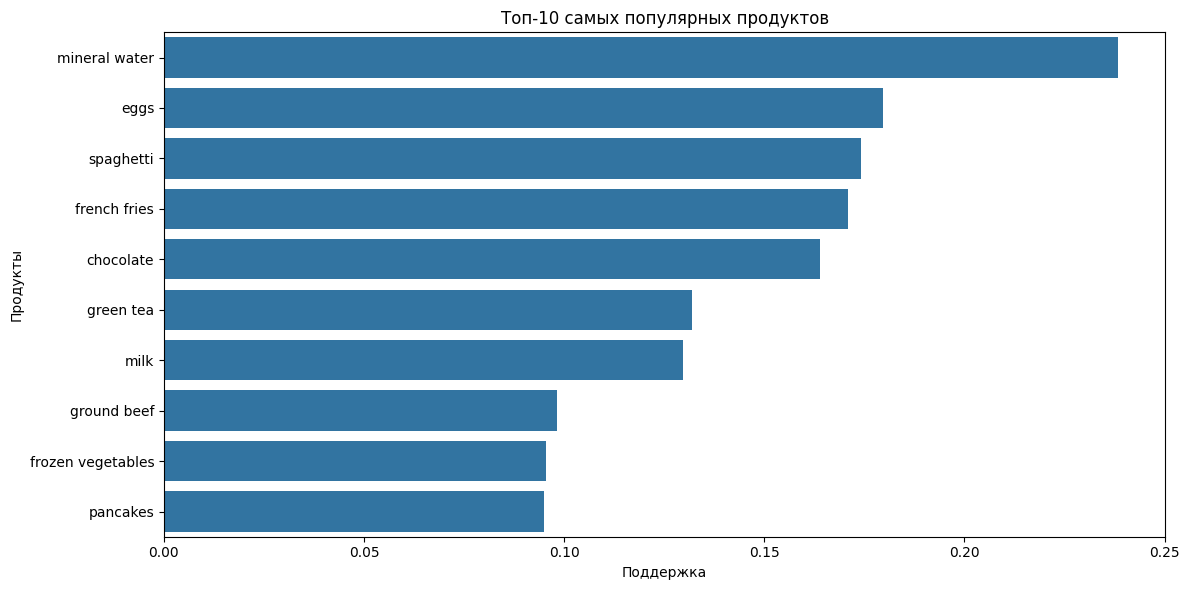

In [34]:
#Поддержка
df1['itemsets'] = df1['itemsets'].apply(lambda x: ', '.join(list(x)))
top_products = df1.sort_values(by='support', ascending=False).head(10)
print(top_products)
plt.figure(figsize=(12, 6))
sns.barplot(x='support', y='itemsets', data=top_products)
plt.title('Топ-10 самых популярных продуктов')
plt.xlabel('Поддержка')
plt.ylabel('Продукты')
plt.tight_layout()
plt.show()

Выведем самые популярные продукты, найденные алгоритмом.

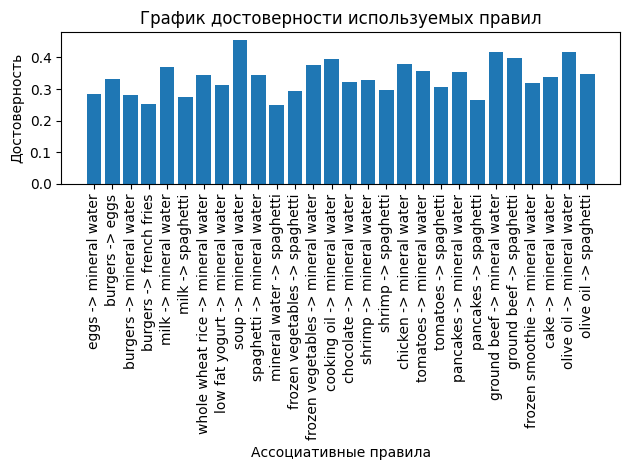

In [35]:
rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))

#График достоверности используемых правил
products_1 = rules["antecedents"].tolist()
products_2 = rules["consequents"].tolist()
confidence = rules["confidence"].tolist()
rules_labels = [f"{product1} -> {product2}" for product1, product2 in zip(products_1, products_2)]
plt.bar(rules_labels, confidence)
plt.xlabel("Ассоциативные правила")
plt.ylabel("Достоверность")
plt.title("График достоверности используемых правил")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Диаграмма, показывающая достоверности, найденные еще при association_rules().

C:\Users\ggleb\AppData\Local\Temp\ipykernel_27776\3501180841.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


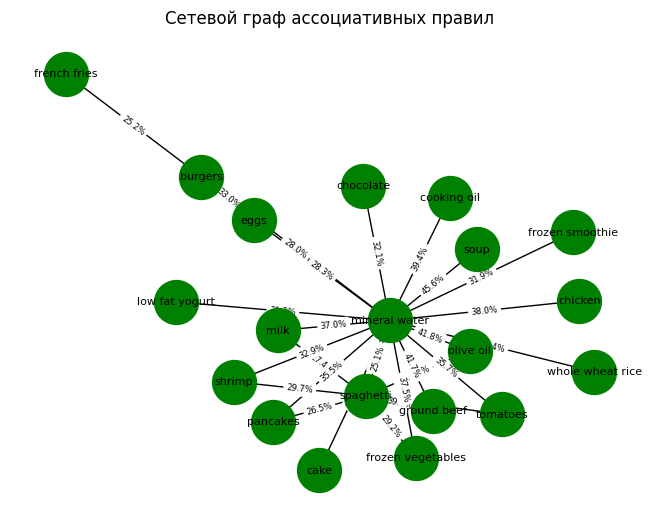

In [36]:
G = nx.Graph()
for product in rules["antecedents"]:
    G.add_node(product)
for product in rules["consequents"]:
    G.add_node(product)
for index, row in rules.iterrows():
    G.add_edge(row['antecedents'], row['consequents'], weight=row['confidence'])
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='green', font_size=8)
edge_labels = {k: f"{v*100:.1f}%" for k, v in nx.get_edge_attributes(G, 'weight').items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)
plt.title('Сетевой граф ассоциативных правил')
plt.tight_layout()
plt.show()

Узлы графа представляют собой продукты, ребра - достоверность. По графу можно оценить, с какой вероятностью покупатель выберет товар В, если он выбрал товар А.

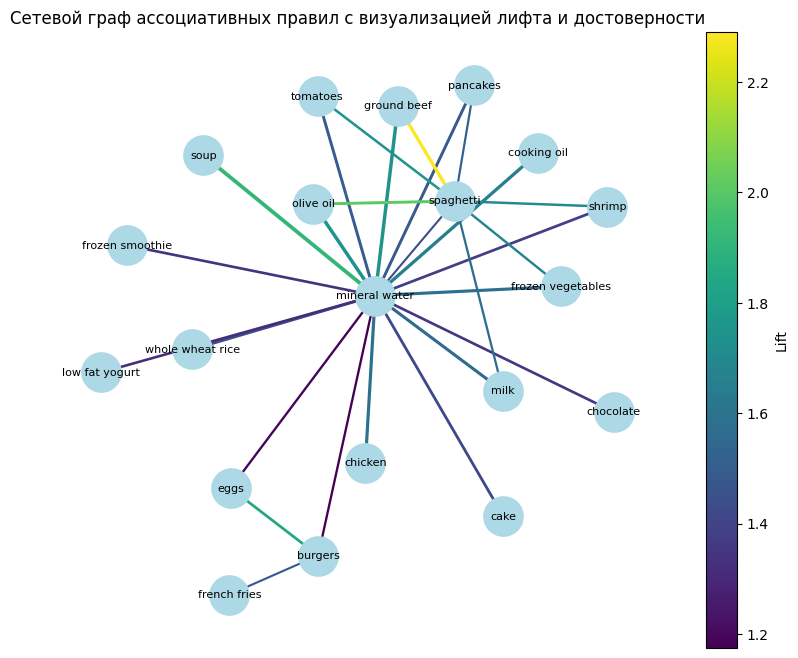

In [ ]:
G = nx.Graph()
for _, row in rules.iterrows():
    a = row['antecedents']
    c = row['consequents']
    G.add_edge(a, c, weight=row['confidence'], lift=row['lift'])

pos = nx.spring_layout(G, k=0.8)
edges = G.edges(data=True)

edge_colors = [d['lift'] for (_, _, d) in edges]
edge_widths = [d['weight'] * 6 for (_, _, d) in edges]

plt.figure(figsize=(10, 8))
nodes = nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=800)
edges = nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_colors, edge_cmap=plt.cm.viridis)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.colorbar(edges, label='Lift')
plt.title('Сетевой граф ассоциативных правил с визуализацией лифта и достоверности')
plt.axis('off')
plt.show()

Визуализируем данные в виде графа, где узел - всё тот же продукт, ребра же будут разной толщины(чем больше, тем больше confidence) и иметь разный цвет(изменение lift в легенде). Такая визуализация позволяет оценивать lift и confidence без нагромождения цифр, однако менее информативна.